In [12]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pyHalo.preset_models import CDM
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [13]:
# open pickled lens list
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)
assert len(lens_list) != 0, f'No pickled lenses found. Check {pickled_lens_list}.'
count = len(lens_list)

In [14]:
success = 0
fail = 0
success_list = []
fail_list = []

for i in tqdm(range(400)):
    lens = np.random.choice(lens_list)

    pipeline_params = util.hydra_to_dict(config.pipeline)
    subhalo_cone = pipeline_params['subhalo_cone']
    los_normalization = pipeline_params['los_normalization']

    # circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
    z_lens = round(lens.z_lens, 2)
    z_source = round(lens.z_source, 2)

    log_m_host = np.log10(lens.main_halo_mass)
    r_tidal = 0.5  # see Section 3.1 of Gilman et al. 2020 https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.6077G/abstract 
    sigma_sub = 0.055  # see Section 6.3 of Gilman et al. 2020 https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.6077G/abstract 

    try:
        cdm_realization = CDM(z_lens,
                    z_source,
                    sigma_sub=sigma_sub,
                    log_mlow=6.,
                    log_mhigh=10.,
                    log_m_host=log_m_host,
                    r_tidal=r_tidal,
                    cone_opening_angle_arcsec=subhalo_cone,
                    LOS_normalization=los_normalization)
        success += 1
        success_list.append(lens)
    except:
        fail += 1
        fail_list.append(lens)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:41<00:00,  2.47it/s]


In [15]:
print(f'Success: {success}, Fail: {fail}, Success rate: {success/(success+fail)}')

Success: 284, Fail: 116, Success rate: 0.71


In [16]:
for lens in success_list:
    print(lens.main_halo_mass)

13334867831.620075
2217396153.4417
101916917579.3952
7207599191.912762
4810308565.874229
22831662110.25759
27903188898.964638
35780360032.990456
145821935507.98294
325891356.05197144
6402504838.900127
2146787292.0444736
417914757.0983629
3285610018.696781
42984247737.967255
4125638757.1907005
7536620828.851116
417914757.0983629
6496049618.891281
42683350480.38273
5139256883.26236
35780360032.990456
4193649461.909071
6557329526.97377
9320636152.33271
20585222540.9803
1757098158.4566307
2387806603.289873
42984247737.967255
806069306.2296114
6503867239.669815
16014153846.232471
581614771.0870304
29426469462.374413
131615318837.41278
17730722192.007915
28071321735.88288
35640199835.98321
6006154208.858452
2332565420.7823353
8563740033.666508
51296905109.101395
2146787292.0444736
1634806758.090538
2799976549.636389
7536620828.851116
10448118413.4015
4316966447.39299
27265317848.117325
34032880866.49539
2498999749.6817303
1619854688.4007015
154276.6676683426
10328587620.48251
1090947795.4548

In [17]:
for lens in fail_list:
    print(lens.main_halo_mass)

-391189511.2587228
-239464839.73577785
-103328898.3990202
-164771723.62156963
-416891008.04207087
-316573911.3504281
-387935767.65165854
-205745118.27131128
-208007459.27155757
-326064457.65438616
-406882094.6264324
-379412853.8450999
-371582220.78401136
-368259753.6706743
-352269494.7433989
-391634132.71470165
-364093590.5418594
-14674973.013881683
-367315352.49697113
-326064457.65438616
-327122882.1293392
-357805284.51773024
-14674973.013881683
-401764696.1221552
-353369438.6054238
-417751836.27034616
-363360439.81076956
-408693216.4265654
-387935767.65165854
-391080420.72473335
-417540658.03828216
-416891008.04207087
-395849046.69235396
-222165505.43904734
-408693216.4265654
-234275118.6770724
-354013751.9813986
-387935767.65165854
-371582220.78401136
-376344097.0063205
-77695265.11476421
-402485693.0815649
-251896636.33973694
-237269602.6402254
-367661999.99817514
-79425833.50446701
-166309334.78227234
-327122882.1293392
-415435185.30135083
-417751836.27034616
-208007459.27155757
-

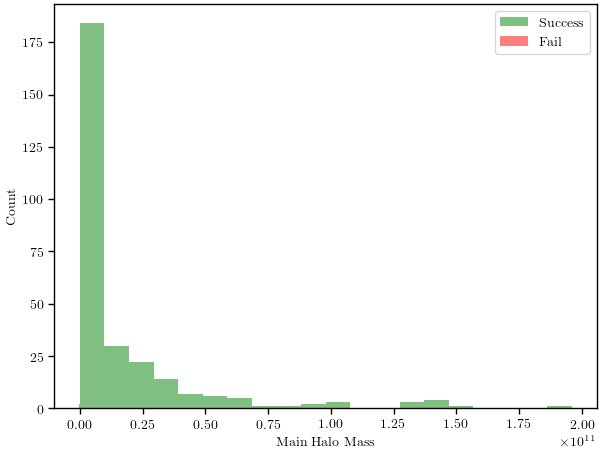

In [18]:
plt.hist([lens.main_halo_mass for lens in success_list], bins=20, alpha=0.5, label='Success', color='g')
plt.hist([lens.main_halo_mass for lens in fail_list], bins=20, alpha=0.5, label='Fail', color='r')
plt.xlabel('Main Halo Mass')
plt.ylabel('Count')
plt.legend()
plt.show()

In [19]:
# fig = plt.figure(2)
# fig.set_size_inches(14,12)
# ax = plt.subplot(111, projection='3d')
# cdm_realization.plot(ax)